In [43]:
%pip install numpy
%pip install dataclasses
%pip install scipy
%pip install matplotlib
%pip install torch


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [299]:
import numpy as np
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from scipy.optimize import root
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [45]:
@dataclass
class KerrOrbitData:
    lam_true: np.ndarray
    r_true: np.ndarray
    phi_true: np.ndarray
    x_true: np.ndarray
    y_true: np.ndarray

    lam_obs: np.ndarray
    x_obs: np.ndarray
    y_obs: np.ndarray

    M_true: float
    a_true: float
    E_true: float
    L_true: float
    r_peri: float
    r_apo: float

In [46]:
def generate_synthetic_orbit(
    M: float = 1.0,
    a: float = 0.6,
    r_peri: float = 6.0,
    r_apo: float = 10.0,
    n_rad_periods: int = 1,
    n_true_pts_per_segment: int = 400,
    n_obs_pts: int = 60,
    noise_std_frac: float = .002,
    seed: int = 0,
) -> KerrOrbitData:
    """
    generating bound equatorial kerr geodesic orbit (timelike):
        choosing turning points r_peri and r_apo (closest and farthest radii),
        solving for consts of motion(E,L) s.t. radial potential R(r)=0 at both turning pts,
        integrating 1st-order eqns for r and phi of lambda,
        converting x,y and adding gaussian noise.

    we'll have geo units with g=c=1 to keep units in respect to M.
    """

    rng = np.random.default_rng(seed)

    #kerr helper functoins
    def Delta(r):
        #r^2 - 2Mr + a^2
        return r**2 - 2.0*M*r + a**2

    def P(r, E, L):
        #E*(r^2+a^2) -a*L
        return E*(r**2+a**2)-a*L

    def R(r,E,L):
        # rad potential for eq kerr geodesics
        # p^2 - delta*(r^2+(L-aE)^2)
        Pvalue = P(r,E,L)
        return Pvalue**2 - Delta(r)*(r**2+(L-a*E)**2)

    #solve for (E,l) from turning pts
    #since bound orbit oscillating between rperi and rapo,
    #rad speed = 0 at turning pots so R=0 here
    # solve both eqns R(r_peri,E,L)=0 and R(r_apo,E,L)=0

    def equations(vars):
        E,L= vars
        return np.array([R(r_peri,E,L),R(r_apo,E,L)])

    #making guess of E, close to 1, and L, close to sqrt(r_peri*M)
    guess = np.array([0.95, 3.5])
    print("DEBUG: solving for E, L")
    sol = root(equations, guess, method="hybr")
    print("DEBUG: E, L solved")
    if not sol.success:
        raise RuntimeError(
            f"couldn't solve for E,L\n"
            f"message: {sol.message}"
        )
    E_true,L_true = sol.x

    # ode (r,phi)
    # eq kerr 1-order eqns:
    #dr/dlam = +- sqrt(R)/r^2
    #dphi/dlam = (L-aE)/r^2 + a*P/(Delta*r^2)
    #+- sign flips at turning pts
    # we will integrate piecewise from rperi -> r_apo then back and repeat

    def dphi_dlam(r, E, L):
        return (L -a*E) / (r**2) +(a*P(r,E,L)) /(Delta(r) * r**2)

    def dr_dlam(r, E, L, sign):
        Rval = R(r, E, L)
        #small values<0 can appear from numerical error
        #keep max to 0
        Rval = max(Rval,0.0)
        return sign*np.sqrt(Rval)/(r**2)
    #ode y=r,phi
    def ode(lam,y, E, L, sign):
        r, phi = y
        return np.array([dr_dlam(r,E,L,sign), dphi_dlam(r,E,L)])

    #even for stopping integration when turning pt reached
    def event_turn_pt(r_target,direction):
        def event(lam, y):
            return y[0] - r_target
        event.terminal = True
        event.direction = direction
        return event

    #piece wise
    # A from r_peri to r_apo with sign=+1
    # B from r_apo to r_peri with sign=-1
    #phi acculumates with bound orbit

    lam_all = []
    r_all =[]
    phi_all = []
    max_step=(1.0) / n_true_pts_per_segment
    lam0 =0.0
    r0 = r_peri+1e-6
    phi0 =0.0

    for i in range(n_rad_periods):
        print(f"radial period {i+1}/{n_rad_periods}")
        #peri -> apo: seg A
        evA =event_turn_pt(r_apo,direction=1)
        print('hi')
        solA = solve_ivp(
            fun=lambda lam, y: ode(lam, y, E_true, L_true, +1),
            t_span=(lam0, lam0 + 500),
            y0=np.array([r0, phi0]),
            events=evA,
            max_step=max_step,
            rtol=1e-6, atol=1e-8
        )
        
        if solA.status != 1:
            raise RuntimeError("outgoing segment didn't hit r_apo.")

        #add seg A, skip first point if it isn't the first segment to avoid duplicates
        lam_seg = solA.t
        r_seg = solA.y[0]
        phi_seg = solA.y[1]
        if len(lam_all) > 0:
            lam_seg, r_seg, phi_seg = lam_seg[1:], r_seg[1:], phi_seg[1:]
        lam_all.append(lam_seg)
        r_all.append(r_seg)
        phi_all.append(phi_seg)

        lam0 = solA.t[-1]
        r0 = solA.y[0, -1] - 1e-6
        phi0 = solA.y[1, -1]

        #add seg B: apo->peri
        evB = event_turn_pt(r_peri,direction=-1)
        solB = solve_ivp(
            fun=lambda lam, y: ode(lam, y, E_true, L_true, -1),
            t_span=(lam0, lam0 + 1e6),
            y0=np.array([r0, phi0]),
            events=evB,
            max_step=max_step,
            rtol=1e-6, atol=1e-8
        )
        if solB.status != 1:
            raise RuntimeError("incoming segment didn't hit r_peri.")

        lam_seg = solB.t[1:]
        r_seg = solB.y[0, 1:]
        phi_seg = solB.y[1, 1:]
        lam_all.append(lam_seg)
        r_all.append(r_seg)
        phi_all.append(phi_seg)

        lam0 = solB.t[-1]
        r0 = solB.y[0, -1]
        phi0 = solB.y[1, -1]

    lam_true = np.concatenate(lam_all)
    r_true = np.concatenate(r_all)
    phi_true = np.concatenate(phi_all)

    #polar to x,y
    x_true = r_true * np.cos(phi_true)
    y_true = r_true * np.sin(phi_true)

    #add gaussian
    idx = np.linspace(0, len(lam_true) -1,n_obs_pts).astype(int)
    lam_obs = lam_true[idx]
    x_obs = x_true[idx].copy()
    y_obs = y_true[idx].copy()

    #noise should be fraction of original radius
    scale = np.mean(r_true)
    x_obs+=rng.normal(0.0, noise_std_frac*scale, size=x_obs.shape)
    y_obs +=rng.normal(0.0, noise_std_frac*scale, size=y_obs.shape)

    return KerrOrbitData(
        lam_true=lam_true,
        r_true=r_true,
        phi_true=phi_true,
        x_true=x_true,
        y_true=y_true,
        lam_obs=lam_obs,
        x_obs=x_obs,
        y_obs=y_obs,
        M_true=M,
        a_true=a,
        E_true=E_true,
        L_true=L_true,
        r_peri=r_peri,
        r_apo=r_apo,
    )

In [127]:
def derivative(y, x):
    """
    Helper function to compute dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

In [324]:
class BlackHolePINN(nn.Module):
    # PINN learns r(λ) and φ(λ) constrained by Kerr geodesic equations,
    # and infers the black hole mass via an inverse physics-informed problem.
    def __init__(self, r0, phi0=0.0, n_hidden=20, a=0.6, M=.5, E=0.95, L=3.5):
        super(BlackHolePINN, self).__init__()

        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 2)
        )

        # define our parameters for the model to learn
        self.M_raw = nn.Parameter(torch.tensor(M))
        self.E = nn.Parameter(torch.tensor(E))
        self.L = nn.Parameter(torch.tensor(L))

        # constant parameters (spin, initial position, initial angle)
        self.a = a

        self.r0 = torch.tensor(r0, dtype=torch.float32)
        self.phi0 = torch.tensor(phi0, dtype=torch.float32)

    @property
    def M(self):
        return nn.functional.softplus(self.M_raw)

    def forward(self, lam):
        """
        Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1), output shape (batch_size, 1)
        lam - current Mino time
        """
        out = self.net(lam)

        # parse r and phi from our output when we evaluate our neural network on the current lambda
        r = out[:, 0:1]
        phi = out[:, 1:2]

        return r, phi
    
    def physics_loss(self, lam):
        """
        Compare the predicted dr/dl and dphi/dl with the Kerr geodesics equations:
            (dr/dλ)^2 = R(r) / r^4,
            dφ/dλ = (L - aE)/r^2 + a P(r)/(Δ(r) r^2)
        """
        # lambda must have requires_grad = True for autograd to work
        lam = lam.clone().detach().requires_grad_(True)

        # calculate our predicted r and phi from ours model
        r_pred, phi_pred = self(lam)

        # calculate derivatives for residual calculations
        dr_dl_pred = derivative(r_pred, lam)
        dphi_dl_pred = derivative(phi_pred, lam)

        # For each lambda (i.e. Mino time), calculate residual losses
        M = self.M
        E = self.E
        L = self.L
        a = self.a

        # very small epsilon to make sure no divide by zeros occur
        eps = 1e-6
        r = r_pred + eps

        # our geodesics equations predicted outputs for dr/dl and dphi/dl
        Delta = r**2 - 2.0 * M * r + a**2
        P = E * (r**2 + a**2) - a * L
        R = P**2 - Delta * (r**2 + (L - a * E)**2)
        
        dr_dl_true = torch.sqrt(torch.abs(R / r**4)) * torch.sign(dr_dl_pred)
        dphi_dl_true = (L - a * E) / r**2 + (a * P) / (Delta * r**2)

        # calculate radial loss and azimuthal angle loss
        radial_loss = torch.mean((dr_dl_pred - dr_dl_true)**2) / torch.mean(dr_dl_true**2)
        azimuthal_loss = torch.mean((dphi_dl_pred - dphi_dl_true)**2) / torch.mean(dphi_dl_true**2)

        return radial_loss, azimuthal_loss

    def initial_condition_loss(self):
        """
        Enforce r(0) = r0 and phi(0) = phi0
        """
        # Evaluate at lambda=0
        l0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)

        # get r0 predicted and phi0 predicted from our model
        r0_pred, phi0_pred = self(l0)

        # check loss vs r0 and phi0
        r_loss = (r0_pred - self.r0).pow(2)
        phi_loss = (phi0_pred - self.phi0).pow(2)

        # return residual loss
        return (r_loss + phi_loss).mean()

    def data_loss(self, l_data, x_data, y_data):
        """
        MSE between predicted r(l_i), phi(l_i) and noisy measurements x_data and y_data.
        """
        
        # get predicted x and y from our model
        r_pred, phi_pred = self(l_data)

        # convert polar coordinates to cartesian
        x_pred = r_pred * torch.cos(phi_pred)
        y_pred = r_pred * torch.sin(phi_pred)

        # evaluate our residual loss from the data
        return torch.mean((x_pred - x_data)**2 + (y_pred - y_data)**2)

Equations to learn from:
$$
\left(\frac{dr}{d\lambda} \right)^2=\frac{R(r)}{r^4}
$$
and
$$
\frac{d\phi}{d\lambda}=\frac{L-aE}{r^2}+\frac{aP(r)}{\Delta(r)r^2}
$$

Our data lives in
$$
(\lambda_i,x_i,y_i)
$$

Our network outputs
$$
r(\lambda),\phi(\lambda)
$$

So, our measurement model is
$$
\hat{x}(\lambda)=r(\lambda)\cos\phi(\lambda),\quad\hat{y}(\lambda)=r(\lambda)\sin\phi(\lambda)
$$
with a data loss function
$$
\mathcal{L}_{\text{data}}=\sum_i \left( |\hat{x}(\lambda_i)-x_i|^2+|\hat{y}(\lambda_i)-y_i|^2 \right)
$$

DEBUG: solving for E, L
DEBUG: E, L solved
radial period 1/1
hi
done


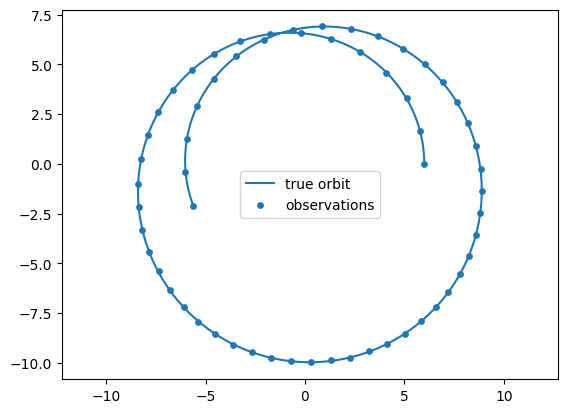

True M, a: 1.0 0.6
r min / max: 6.0 10.0


In [200]:
data = generate_synthetic_orbit(M=1.0)

print('done')

plt.figure()
plt.plot(data.x_true, data.y_true, label="true orbit")
plt.scatter(data.x_obs, data.y_obs, s=15, label="observations")
plt.axis("equal")
plt.legend()
plt.show()

print("True M, a:", data.M_true, data.a_true)
print("r min / max:", data.r_true.min(), data.r_true.max())

In [291]:
# data = generate_synthetic_orbit()
# start at perihelion
r0 = data.r_peri
phi0 = 0.0
a = data.a_true

# Hyperparameters for weighting the loss terms
lambda_data = 5.0
lambda_ic   = 2.0
lambda_ode  = 0.1

# For logging
num_epochs = 4000
print_every = 200

l_data_tensor = torch.tensor(data.lam_obs, dtype=torch.float32).unsqueeze(1)
x_data = torch.tensor(data.x_obs, dtype=torch.float32).unsqueeze(1)
y_data = torch.tensor(data.y_obs, dtype=torch.float32).unsqueeze(1)

In [318]:
M_init = float(0.5 + 0.5 * np.random.rand())
E_init = float(0.8 + 0.4 * np.random.rand())
L_init = float(2.0 + 2.0 * np.random.rand())

print(f"Intial Model Mass M = {M_init:.4f}, E = {E_init:.4f}, L = {L_init:.4f}\n")

Intial Model Mass M = 0.6503, E = 0.9818, L = 2.8703



In [329]:
model = BlackHolePINN(r0=r0, phi0=phi0, a=a, M=M_init, E=E_init, L=L_init)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

total_losses = []
data_losses = []
ode_losses_r = []
ode_losses_phi = []
ic_losses = []
lams = []

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute losses
    l_data = model.data_loss(l_data_tensor, x_data, y_data)
    l_ode_r, l_ode_phi = model.physics_loss(l_data_tensor)
    l_ic   = model.initial_condition_loss()

    # penalize bad params to prevent negative mass
    param_loss = 0.1*((model.M - 1.0)**2 + (model.E - 0.95)**2 + (model.L - 3.2)**2)

    # Combined loss
    loss = lambda_data * l_data + lambda_ode * (l_ode_r + l_ode_phi) + lambda_ic * l_ic + param_loss

    # Backprop
    loss.backward()
    optimizer.step()

    total_losses.append(loss.item())
    data_losses.append(l_data.item())
    ode_losses_r.append(l_ode_r.item())
    ode_losses_phi.append(l_ode_phi.item())
    ic_losses.append(l_ic.item())

    # Print progress
    if (epoch) % print_every == 0:
        print(f"Epoch {epoch}/{num_epochs}:\n"
              f"Total Loss = {loss.item():.6f}\n"
              f"Data Loss = {l_data.item():.6f}\n"
              f"Radial Loss = {l_ode_r.item():.6f}\nAzimuthal Loss = {l_ode_phi.item():.6f}\n"
              f"IC Loss = {l_ic.item():.6f}\n")

Epoch 0/4000:
Total Loss = 415.417969
Data Loss = 69.194550
Radial Loss = 0.999349
Azimuthal Loss = 1.000127
IC Loss = 34.616905

Epoch 200/4000:
Total Loss = 340.779114
Data Loss = 64.591888
Radial Loss = 0.999427
Azimuthal Loss = 1.000079
IC Loss = 8.807051

Epoch 400/4000:
Total Loss = 165.709305
Data Loss = 32.338657
Radial Loss = 0.910137
Azimuthal Loss = 1.000729
IC Loss = 1.911051

Epoch 600/4000:
Total Loss = 48.943943
Data Loss = 9.668784
Radial Loss = 0.776184
Azimuthal Loss = 0.684939
IC Loss = 0.223828

Epoch 800/4000:
Total Loss = 15.158533
Data Loss = 3.004500
Radial Loss = 0.963671
Azimuthal Loss = 0.089903
IC Loss = 0.012154

Epoch 1000/4000:
Total Loss = 7.669505
Data Loss = 1.510872
Radial Loss = 1.025078
Azimuthal Loss = 0.041450
IC Loss = 0.002483

Epoch 1200/4000:
Total Loss = 5.659739
Data Loss = 1.109311
Radial Loss = 1.019943
Azimuthal Loss = 0.068743
IC Loss = 0.001019

Epoch 1400/4000:
Total Loss = 4.350272
Data Loss = 0.846884
Radial Loss = 1.016508
Azimuthal

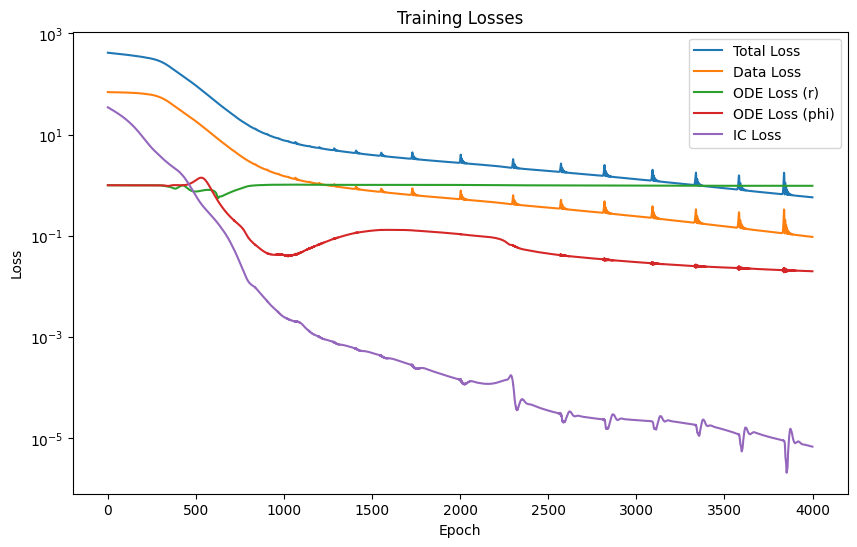

In [330]:
plt.figure(figsize=(10,6))
plt.plot(total_losses, label='Total Loss')
plt.plot(data_losses, label='Data Loss')
plt.plot(ode_losses_r, label='ODE Loss (r)')
plt.plot(ode_losses_phi, label='ODE Loss (phi)')
plt.plot(ic_losses, label='IC Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [331]:
# Put model in evaluation mode
model.eval()

with torch.no_grad():
    lam_full = torch.tensor(data.lam_true, dtype=torch.float32).unsqueeze(1)  # full trajectory
    r_pred, phi_pred = model(lam_full)
    x_pred = r_pred * torch.cos(phi_pred)
    y_pred = r_pred * torch.sin(phi_pred)

# Access learned parameters
M_learned = model.M.item()
E_learned = model.E.item()
L_learned = model.L.item()
print(f"Learned Mass M = {M_learned:.4f}, E = {E_learned:.4f}, L = {L_learned:.4f}")
print(f"Expected Mass M = {data.M_true:.4f}, E = {data.E_true:.4f}, L = {data.L_true:.4f}")

Learned Mass M = 1.0618, E = 1.0319, L = 3.2326
Expected Mass M = 1.0000, E = 0.9432, L = 3.2126


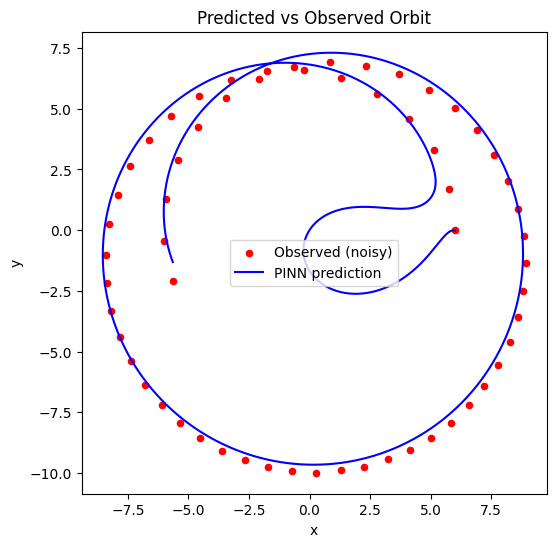

In [332]:
plt.figure(figsize=(6,6))
plt.scatter(x_data, y_data, color='red', label='Observed (noisy)', s=20)
plt.plot(x_pred.numpy(), y_pred.numpy(), color='blue', label='PINN prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted vs Observed Orbit')
plt.axis('equal')  # Important for circular/elliptical orbits
plt.legend()
plt.show()